# Apply linear drift correction to upper ocean fields in CESM1-LE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import cftime
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pop_tools

import metabolic
import util
import data_collections

In [3]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(34)
client    

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.59:40694,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load data with intake-esm

[Intake-esm](https://intake-esm.readthedocs.io/en/latest/) provides a API to CESM1-LE data.

In [4]:
ctrl_drift = data_collections.drift(experiment='CTRL', stream='pop.h')
ctrl_drift

{ 'esm_collection': 'data/catalogs/glade-cesm1-le.json',
  'name': 'linear-drift',
  'operator_kwargs': [ { },
                       { },
                       { }],
  'operators': [ 'compute_time',
                 'sel_time_slice',
                 'compute_drift'],
  'preprocess': '_preprocess_pop_h_upper_1km'}

In [5]:
ctrl_drift._cache_files

{'37abaecb560214dea1fad9d005f96481': '/glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.CTRL.ocn.pop.h.001.O2_CONSUMPTION.linear-drift.zarr',
 '614f74b1ebc2a91715ffc087e1d96266': '/glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.CTRL.ocn.pop.h.001.O2_PRODUCTION.linear-drift.zarr',
 '8fcc769db7d90e1e1d00b5f08b3a3a4a': '/glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.CTRL.ocn.pop.h.001.SALT.linear-drift.zarr',
 '9202145d6037a88a609827093704966c': '/glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.CTRL.ocn.pop.h.001.TEMP.linear-drift.zarr',
 'b944f7d7bc08d0c2be543296a50edd6b': '/glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.CTRL.ocn.pop.h.001.O2.linear-drift.zarr'}

In [6]:
%%time
ds_drift = ctrl_drift.to_dataset_dict(variable=['O2'], clobber=False)
ds_drift

CPU times: user 362 ms, sys: 126 ms, total: 487 ms
Wall time: 713 ms


{'CTRL.ocn.pop.h.1': <xarray.Dataset>
 Dimensions:  (nlat: 384, nlon: 320, z_t: 40)
 Coordinates:
     KMT      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TAREA    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     dz       (z_t) float32 dask.array<chunksize=(10,), meta=np.ndarray>
   * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
 Dimensions without coordinates: nlat, nlon
 Data variables:
     O2       (z_t, nlat, nlon) float64 dask.array<chunksize=(10, 384, 320), meta=np.ndarray>}

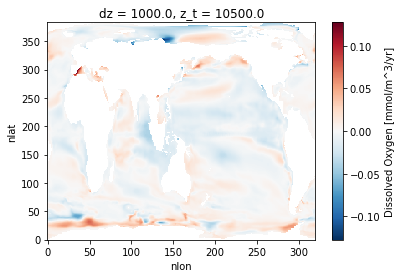

In [7]:
ds_drift['CTRL.ocn.pop.h.1'].O2.isel(z_t=10).plot()

In [8]:
variables = ['O2', 'TEMP', 'SALT', 'O2_CONSUMPTION', 'O2_PRODUCTION'] #'Jint_100m_DIC', 'photoC_sp', 'photoC_diat', 'photoC_diaz']
experiments = ['20C', 'RCP85']
stream = 'pop.h'
drft_corr = data_collections.drift_corrected_ens(
    experiment=experiments, 
    stream=stream, 
)
drft_corr

{ 'esm_collection': 'data/catalogs/glade-cesm1-le.json',
  'name': 'drift-corrected',
  'operator_kwargs': [ { },
                       { },
                       { }],
  'operators': [ 'compute_time',
                 'sel_time_slice',
                 'compute_drift_correction'],
  'preprocess': '_preprocess_pop_h_upper_1km'}

In [9]:
import yaml
print(yaml.dump(drft_corr._cache_files))

04497132dae54113e1a131b9633844a2: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.026.O2_PRODUCTION.drift-corrected.zarr
048301bf29a5afac393f707c66eb2cde: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.032.SALT.drift-corrected.zarr
059de953590f50bdb7e02fdbb4ab46b0: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.030.O2_CONSUMPTION.drift-corrected.zarr
05b1141a8521818acb8a4e949930ccc8: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.O2_PRODUCTION.drift-corrected.zarr
05e7d2426e939ff42771c116fc85bb03: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.002.TEMP.drift-corrected.zarr
06ceeabd62d3e281b8a45281b50cc59e: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.030.TEMP.drift-corrected.zarr
06ec06f76d06333445f0fce90891c1f7: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le

In [10]:
%%time
dsets = drft_corr.to_dataset_dict(variable=variables, clobber=False)
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id'


CPU times: user 9.45 s, sys: 650 ms, total: 10.1 s
Wall time: 2min 4s


{'20C.ocn.pop.h.2': <xarray.Dataset>
 Dimensions:         (nlat: 384, nlon: 320, time: 1032, z_t: 40, d2: 2, z_t_150m: 15)
 Coordinates:
     KMT             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TAREA           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLAT            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULAT            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULONG           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     dz              (z_t) float32 dask.array<chunksize=(10,), meta=np.ndarray>
   * time            (time) object 1920-01-17 00:29:59.999993 ... 2005-12-16 1...
     time_bound      (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
   * z_t             (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.